# Transfer Learning - Cat X Dogs

Implementação de rede convolucional usando transfer learning para diferenciação das categorias gato e cachorro.

bibliotecas necessárias para manipulação de arquivos, compressão, geração de números aleatórios, criação e treinamento do modelo de rede neural, e cópia de arquivos:

In [ ]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

Este comando abaixo baixa um arquivo zip contendo o dataset de imagens de gatos e cachorros:

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2024-12-12 13:00:14--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.38.253.179, 2600:1407:7400:1187::317f, 2600:1407:7400:1184::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.38.253.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   110MB/s    in 8.8s    

2024-12-12 13:00:23 (88.9 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



Os print() abaixo imprimem a quantidade de imagens de gatos e cachorros no dataset:

In [ ]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


Os diretórios necessários são criados para organizar as imagens de treinamento e teste:

In [ ]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

Essa função divide os arquivos em conjuntos de treinamento e teste com base em uma taxa de divisão:

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"

DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = 0.9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)


666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Os print() imprimem a contagem de arquivos em cada pasta após a divisão.

In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


O modelo é definido com várias camadas convolucionais e de pooling, seguido por uma camada densa para a classificação:

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Os geradores de dados são configurados para aplicar diversas transformações nas imagens de treino e validação, incluindo redimensionamento, rotações e flips:

In [ ]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"

validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


O modelo é treinado por 15 épocas:

In [20]:
history = model.fit(train_generator, epochs=15, steps_per_epoch=90,
                    validation_data=validation_generator, validation_steps=6)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - acc: 0.5229 - loss: 0.7552 - val_acc: 0.5550 - val_loss: 0.6821
Epoch 2/15
10/90 ━━━━━━━━━━━━━━━━━━━━ 4:16 3s/step - acc: 0.5430 - loss: 0.6898

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - acc: 0.5779 - loss: 0.6778 - val_acc: 0.6283 - val_loss: 0.6338
Epoch 3/15
45/90 ━━━━━━━━━━━━━━━━━━━━ 2:22 3s/step - acc: 0.6280 - loss: 0.6387

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


90/90 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - acc: 0.6319 - loss: 0.6361 - val_acc: 0.6583 - val_loss: 0.6133
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 339s 4s/step - acc: 0.6343 - loss: 0.6377 - val_acc: 0.6033 - val_loss: 0.6294
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - acc: 0.6602 - loss: 0.6126 - val_acc: 0.6600 - val_loss: 0.5880
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - acc: 0.6590 - loss: 0.6126 - val_acc: 0.7133 - val_loss: 0.5724
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - acc: 0.6746 - loss: 0.5981 - val_acc: 0.7033 - val_loss: 0.5882
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - acc: 0.6996 - loss: 0.5786 - val_acc: 0.7133 - val_loss: 0.5508
Epoch 9/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - acc: 0.6905 - loss: 0.5810 - val_acc: 0.6900 - val_loss: 0.5839
Epoch 10/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - acc: 0.6985 - loss: 0.5690 - val_acc: 0.6500 - val_loss: 0.5857
Epoch 11/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - acc: 0.7016 - loss: 

Este bloco de código plota as métricas de precisão e perda para os dados de treinamento e validação ao longo das épocas:

<Figure size 640x480 with 0 Axes>

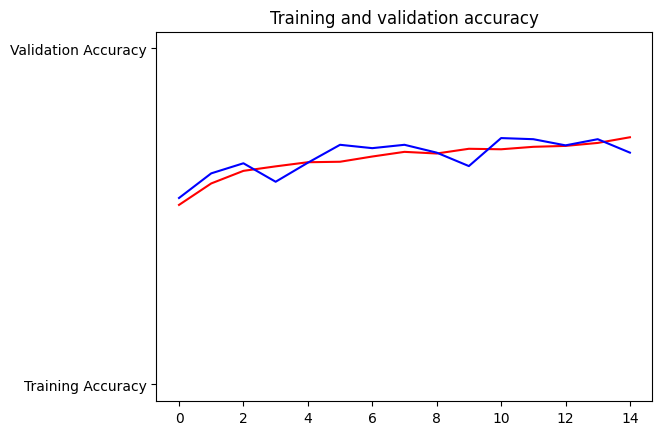

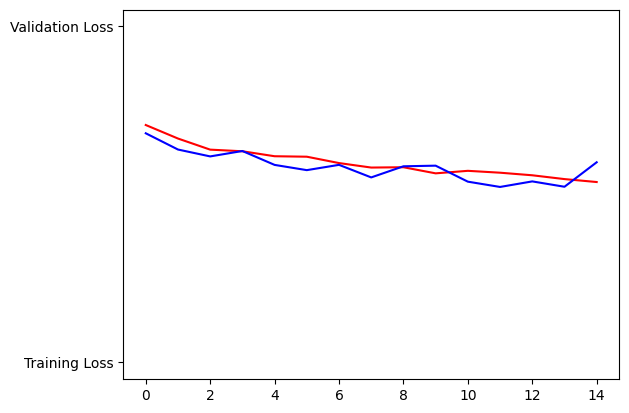

<Figure size 640x480 with 0 Axes>

In [21]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)


1. Gráfico de Acuráia:
  - Linha Vermelha ("Training Accuracy"): Mostra a acurácia do modelo no conjunto de treinamento. Podemos ver que essa linha sobe consistentemente à medida que o número de épocas aumenta, indicando que o modelo está aprendendo e melhorando suas previsões.
  - Linha Azul ("Validation Accuracy"): Mostra a acurácia do modelo no conjunto de validação. Ela também aumenta, mas com algumas flutuações. Essas flutuações são normais e indicam que o modelo está sendo testado em dados que não viu durante o treinamento.
  - A curva de acurácia de validação (azul) é importante para entender se o modelo está generalizando bem para dados não vistos. Se a acurácia de validação fosse significativamente menor do que a acurácia de treinamento, poderia indicar overfitting (quando o modelo memoriza os dados de treinamento ao invés de aprender padrões gerais).

2. Gráfico de Perda:
  - Linha Vermelha ("Training Loss"): Mostra a perda do modelo no conjunto de treinamento. A perda diminui ao longo do tempo, o que é um bom sinal, pois indica que o modelo está melhorando.
  - Linha Azul ("Validation Loss"): Mostra a perda do modelo no conjunto de validação. Ela também diminui, mas com algumas flutuações.
  - Perda é uma métrica que indica o quão bem o modelo está se ajustando aos dados. Um valor menor de perda é melhor. A curva de perda de validação (azul) é crucial porque, se ela começar a aumentar enquanto a perda de treinamento continua a diminuir, isso pode ser um sinal de overfitting.

Por fim, o comando abaixo acessa e guarda nosso notebook no Google Drive:

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
